In [18]:
import pickle
import sys
import csv
sys.path.append(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project')
from execute_remote_scripts import *
# from Processing_Data.downsampling import *
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
%load_ext autoreload
%autoreload 2
# from Server_Scripts.remote_processing_csv import *
from Processing_Data.EDA import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Probability Density Functions of the Data

In [3]:
base_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files'
files = os.listdir(base_path)
# Loading all csv files into a diciotnary
dataframes = {}
for file in files:
    dataframes[int(file.split('.')[0].split('no')[1])] = pd.read_csv(os.path.join(base_path, file))
    
RE_autom = list(pd.read_csv(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\automatic_RE_numbers.csv', header=None)[0])
RE_valid = list(pd.read_csv(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\validated_RE_numbers.csv', header=None)[0])

In [4]:
# Checking for NaNs and Infs and dropping them if necessary
check_nans_infs(dataframes, drop=True)

# Updating the shot lists
RE_autom = [shot for shot in RE_autom if shot in dataframes.keys()]
RE_valid = [shot for shot in RE_valid if shot in dataframes.keys()]
NO_RE_probably = [key for key in dataframes.keys() if key not in RE_autom and key not in RE_valid]

# Extracting the keys of the variables
features = list(dataframes[NO_RE_probably[0]].keys()) #to_numpy()
features.pop(features.index('time'))
features

DataFrame 83575: NaNs = 178, Infs = 0
DataFrame 83601: NaNs = 273, Infs = 0
DataFrame 84783: NaNs = 558, Infs = 0
DataFrame 85414: NaNs = 775, Infs = 0
DataFrame 89051: NaNs = 155, Infs = 0
DataFrame 89451: NaNs = 645, Infs = 0
DataFrame 90112: NaNs = 804, Infs = 0
DataFrame 91997: NaNs = 414, Infs = 0
DataFrame 92036: NaNs = 647, Infs = 0
DataFrame 92045: NaNs = 680, Infs = 0
Dropped DataFrames: [83575, 83601, 84783, 85414, 89051, 89451, 90112, 91997, 92036, 92045]


['SSXcore', 'IP', 'DAO_EDG7', 'WMHD', 'RNT', 'DAI_EDG7']

In [11]:
import random
print(NO_RE_probably[random.randint(0, len(NO_RE_probably))], RE_valid[random.randint(0, len(RE_valid))])

98574 85948


In [12]:
95732 in RE_valid

True

In [4]:
# Getting the normalised PDFs
RE_features_extrema, RE_features_densities = compute_feature_statistics(dataframes, RE_valid, features)
NO_RE_features_extrema, NO_RE_features_densities = compute_feature_statistics(dataframes, NO_RE_probably, features) 

Error processing feature 'DAI_EDG7' in DataFrame '95774': 'DAI_EDG7'
Error processing feature 'WMHD' in DataFrame '86793': The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Error processing feature 'WMHD' in DataFrame '87722': The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Error processing feature 'WMHD' in DataFrame '90188': The data appears to lie in a lower-dimensional subspace of 

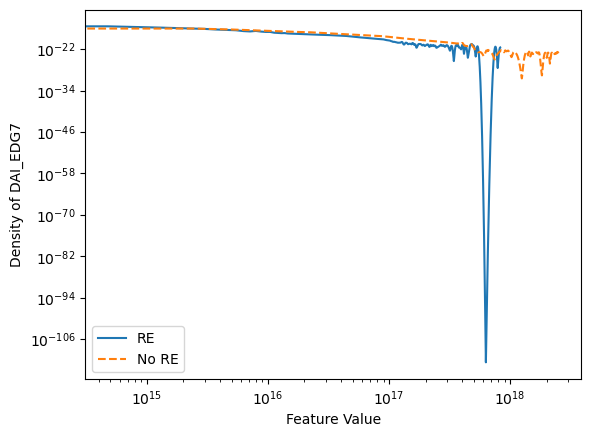

In [6]:
# Plotting and saving them all (log scale optional)
plt.close()
for feature in features:
    plt.close()
    plt.plot(RE_features_densities[feature][0], RE_features_densities[feature][1], label='RE')
    plt.plot(NO_RE_features_densities[feature][0], NO_RE_features_densities[feature][1], '--', label='No RE')
    plt.xlabel('Feature Value')
    plt.ylabel(f'Density of {feature}')
    plt.legend()
    plt.loglog()
    plt.savefig(fr'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\PDFs_DAI\Feature_Density_{feature}_loglog.png')

## Comparing original data with downsampled data

In [14]:
file_original = load_pickle(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\20_random_JET_data.pkl')
original_data = file_original['JETno85000']
downsampled_data = pd.read_csv(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files\JETno85000.csv') # These data are downsampled while downloaded

In [16]:
shot=original_data
SSX = shot['SSXcore']
t_b = shot['Ramp_up'][0]
t_e = shot['Ramp_down'][1]
original_time = SSX['time'][(SSX['time'] >= t_b) & (SSX['time'] <= t_e)]
original_data = SSX['signal'][(SSX['time'] >= t_b) & (SSX['time'] <= t_e)]
print(t_b, t_e)

40.917400001490115 59.467300001490116


In [19]:
plt.close()
plt.plot(original_time, original_data)
plt.plot(downsampled_data['time'], downsampled_data['SSXcore'], '-')
plt.show()

<IPython.core.display.Javascript object>

In [20]:
downsampled_data['time'][1]-downsampled_data['time'][0]

0.018568468499999824

In [22]:
original_time[10]-original_time[9]

3.999999999848569e-05